# NASA JPL ECCO Data

Notebook credit:
- Chelle Gentemann
- Greg Niemeyer 

NASA’s Estimating the Circulation and Climate of the Ocean (ECCO) project supports climate research by providing the scientific community with the best possible multidecadal reconstructions of Earth’s time-evolving full-depth ocean, sea-ice, and atmospheric surface states and their associated fluxes.

ECCO state estimate are multi-platform, multi-instrument, multi-variable synthesis products that integrate global satellite and in-situ ocean and ice observations with coupled ocean/sea-ice models. By construction, ECCO state estimates satisfy the laws of physics and thermodynamics and therefore conserve heat, salt, volume, and momentum. This strict adherence to conservation principles makes ECCO products particularly well-suited for investigations into the origins of observed ocean, sea-ice, and sea-level variability.

The project brings together diverse data streams, including satellite observations (e.g., sea level from the Jason-series satellite altimeters and ocean bottom pressure from the GRACE and GRACE-Follow On missions) and in situ measurements (e.g., temperature and salinity profiles from Argo floats and CTDs) to obtain the best possible estimate of the time evolving ocean circulation and related uncertainties.

- [https://science.jpl.nasa.gov/projects/ecco/](https://science.jpl.nasa.gov/projects/ecco/)
- [https://podaac.jpl.nasa.gov/ECCO](https://podaac.jpl.nasa.gov/ECCO)

ECCO data include:'Eta', 'KPPhbl', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX','oceTAUY', 'PhiBot', 'Salt', 'SIarea', 'SIheff', 'SIhsalt', 'SIhsnow', 'SIuice','SIvice', 'Theta', 'U','V','W'

Since the complete ECCO V4r4 product exceeds 3TB across more than 385,000 granules (!!!), in this notebook, we don't download the large ECCO files. Instead, we access them through the ECCO data portal, using Xarray and lazy loading to only get the data we need.

Steps -
- connect to model data in portal
- get dataset name and read a small portion of the data
- create the downward and upward profiles and link them together
- print a figure of the profile and save the data as a dataframe


In [1]:
import numpy as np
import xarray as xr
import xmitgcm.llcreader as llcreader
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
model = llcreader.ECCOPortalLLC2160Model()
ds = model.get_dataset(varnames=['Salt'], type='latlon')
down_lat = 19.71361
down_lon = -67.00
down_ilat = abs(ds.YC[:,0] - down_lat).argmin()
down_ilon = abs(ds.XC[0,:] - down_lon).argmin()
up_lat =  19.71361
up_lon = -68.00
up_ilat = abs(ds.YC[:,0] - up_lat).argmin()
up_ilon = abs(ds.XC[0,:] - up_lon).argmin()

down_ilat, down_ilon = down_ilat.load(),down_ilon.load()
up_ilat, up_ilon = up_ilat.load(),up_ilon.load()
subset2 = ds.isel(time=-1,j=slice(down_ilat.data-2,down_ilat.data+2),i=slice(down_ilon.data-2,down_ilat.data+2))
array2 = xr.DataArray(subset2.Salt.data,dims=['depth','lat','lon'],coords={'depth':subset2.Z.data,'lat':subset2.YC[:,0].data,'lon':subset2.XC[0,:].data})

In [3]:
depth = 82

down_data = array2.sel(lat=down_lat,lon=down_lon,method='nearest') #Milwaukee Trench

down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
up_data = array2.sel(lat=up_lat,lon=up_lon,method='nearest')
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32


#here we scale the data to the required number of steps
i1=0; i2=depth;
tem = down_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,3600)
down_data2 = tem.interp(depth=depth_new)
down_lowest = down_data2[-1].data #save lowest value

tem = up_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,1699)
up_data2 = tem.interp(depth=depth_new)
up_lowest = up_data2[-1].data #save lowest value

In [4]:
# Create the new depth values and salinity array with 101 values
depth_new = np.linspace(down_data2.depth[-1].data, up_data2.depth[-1].data, 101)  # 101 depth points
sal_new = np.linspace(down_lowest, up_lowest, 101)  # 101 temperature points

# Create `middle_data` with 101 rows
middle_data = pd.DataFrame({'depth': depth_new, 'salinity': sal_new})

In [12]:
print(down_data)

            depth   salinity
0       -0.500000  36.459949
1       -1.616589  36.459573
2       -2.733179  36.459409
3       -3.849768  36.459296
4       -4.966357  36.459201
...           ...        ...
3595 -4014.638623  34.906504
3596 -4015.755212  34.906500
3597 -4016.871802  34.906497
3598 -4017.988391  34.906494
3599 -4019.104980  34.906490

[3600 rows x 2 columns]


In [13]:
indices = down_data[down_data['depth'] < -800].index
print(indices)

Index([ 717,  718,  719,  720,  721,  722,  723,  724,  725,  726,
       ...
       3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599],
      dtype='int64', length=2883)


In [15]:
print(down_data.iloc[717])

depth      -801.094546
salinity     34.945021
Name: 717, dtype: float64


In [6]:
down_data = pd.DataFrame({'depth': down_data2.depth, 'salinity': down_data2})

In [7]:
down_data.shape

(3600, 2)

In [8]:
up_data = pd.DataFrame({'depth': up_data2.depth, 'salinity': up_data2})

In [9]:
up_data.shape

(1699, 2)

In [10]:
#reverse up data
reversed_up_data = up_data.iloc[::-1].reset_index(drop=True)

# Display the reversed DataFrame
print(reversed_up_data)
depth_df = pd.concat([down_data, middle_data, reversed_up_data], ignore_index=True)

            depth   salinity
0    -4019.104980  34.906490
1    -4016.738311  34.906497
2    -4014.371641  34.906505
3    -4012.004972  34.906512
4    -4009.638302  34.906519
...           ...        ...
1694    -9.966678  36.458873
1695    -7.600009  36.459018
1696    -5.233339  36.459180
1697    -2.866670  36.459393
1698    -0.500000  36.459949

[1699 rows x 2 columns]


Text(0, 0.5, 'Salinity')

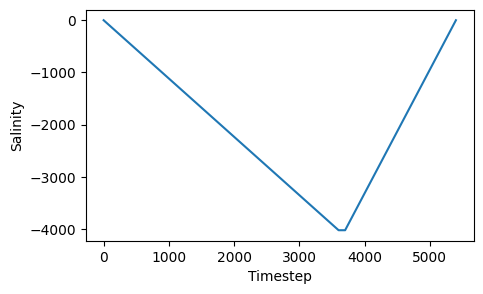

In [11]:
plt.figure(figsize=(5, 3))
plt.plot(depth_df.index,depth_df.depth)
plt.xlabel('Timestep')
plt.ylabel('Salinity')

In [14]:
depth_df.to_csv("../data/trench_dive_salinity.csv", index=True)

# now do temperature (theta)
-restart your kernel!

In [1]:
import numpy as np
import xarray as xr
import xmitgcm.llcreader as llcreader
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
model = llcreader.ECCOPortalLLC2160Model()
ds = model.get_dataset(varnames=['Theta'], type='latlon')
down_lat = 19.71361
down_lon = -67.00
down_ilat = abs(ds.YC[:,0] - down_lat).argmin()
down_ilon = abs(ds.XC[0,:] - down_lon).argmin()
up_lat =  19.71361
up_lon = -68.00
up_ilat = abs(ds.YC[:,0] - up_lat).argmin()
up_ilon = abs(ds.XC[0,:] - up_lon).argmin()

down_ilat, down_ilon = down_ilat.load(),down_ilon.load()
up_ilat, up_ilon = up_ilat.load(),up_ilon.load()
subset2 = ds.isel(time=-1,j=slice(down_ilat.data-2,down_ilat.data+2),i=slice(down_ilon.data-2,down_ilat.data+2))
array2 = xr.DataArray(subset2.Theta.data,dims=['depth','lat','lon'],coords={'depth':subset2.Z.data,'lat':subset2.YC[:,0].data,'lon':subset2.XC[0,:].data})

In [3]:
depth = 82

down_data = array2.sel(lat=down_lat,lon=down_lon,method='nearest') #Milwaukee Trench

down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
up_data = array2.sel(lat=up_lat,lon=up_lon,method='nearest')
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32


#here we scale the data to the required number of steps
i1=0; i2=depth;
tem = down_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,3600)
down_data2 = tem.interp(depth=depth_new)
down_lowest = down_data2[-1].data #save lowest value

tem = up_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,1699)
up_data2 = tem.interp(depth=depth_new)
up_lowest = up_data2[-1].data #save lowest value

In [4]:
down_data = pd.DataFrame({'depth': down_data2.depth, 'temperature': down_data2})
up_data = pd.DataFrame({'depth': up_data2.depth, 'temperature': up_data2})


down_last = down_data.iloc[-1]
up_last = up_data.iloc[-1]

# Generate linearly interpolated values between the last row of down_data and up_data
depth_interpolated = np.linspace(down_last['depth'], up_last['depth'], 101)
temperature_interpolated = np.linspace(down_last['temperature'], up_last['temperature'], 101)

# Create the middle_data DataFrame
middle_data = pd.DataFrame({
    'depth': depth_interpolated,
    'temperature': temperature_interpolated
})

# Display the new DataFrame
print(middle_data)

          depth  temperature
0   -4019.10498     2.141688
1   -4019.10498     2.141688
2   -4019.10498     2.141688
3   -4019.10498     2.141688
4   -4019.10498     2.141688
..          ...          ...
96  -4019.10498     2.141688
97  -4019.10498     2.141688
98  -4019.10498     2.141688
99  -4019.10498     2.141688
100 -4019.10498     2.141688

[101 rows x 2 columns]


In [5]:
#reverse up data
reversed_up_data = up_data.iloc[::-1].reset_index(drop=True)
depth_df = pd.concat([down_data, middle_data, reversed_up_data], ignore_index=True)

In [6]:
depth_df.shape

(5400, 2)

Text(0, 0.5, 'Temperature')

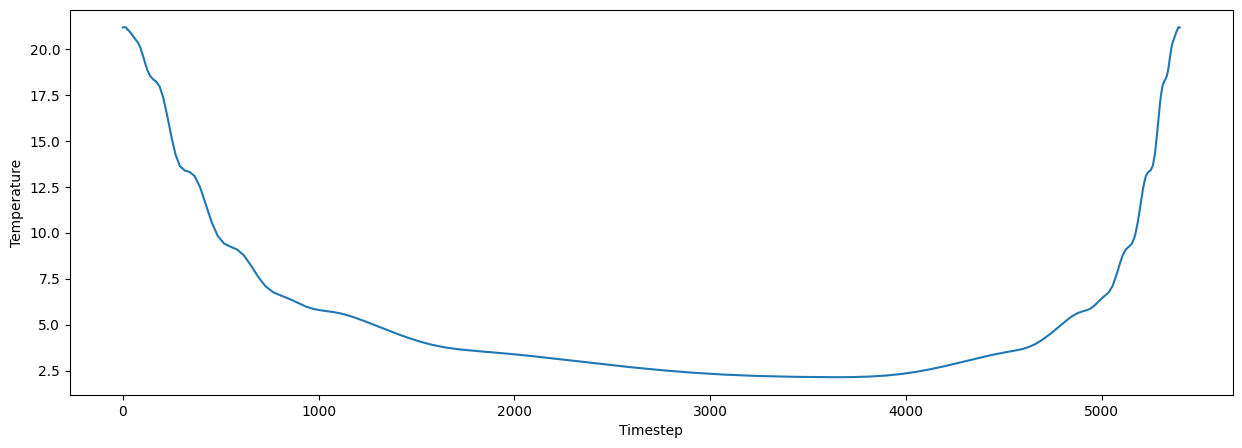

In [8]:
#graph
plt.figure(figsize=(15, 5))
plt.plot(depth_df.index,depth_df['temperature'])
plt.xlabel('Timestep')
plt.ylabel('Temperature')

In [9]:
depth_df.to_csv("../data/trench_dive_temperature.csv", index=True)

# now do velocities
- restart your kernel

In [1]:
import numpy as np
import xarray as xr
import xmitgcm.llcreader as llcreader
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
model = llcreader.ECCOPortalLLC2160Model()
ds = model.get_dataset(varnames=['U', 'V'], type='latlon')

# Define down and up coordinates
down_lat = 19.71361
down_lon = -67.00
down_ilat = abs(ds.YC[:, 0] - down_lat).argmin()
down_ilon = abs(ds.XC[0, :] - down_lon).argmin()

up_lat = 19.71361
up_lon = -68.00
up_ilat = abs(ds.YC[:, 0] - up_lat).argmin()
up_ilon = abs(ds.XC[0, :] - up_lon).argmin()

# Load the index values
down_ilat, down_ilon = down_ilat.load(), down_ilon.load()
up_ilat, up_ilon = up_ilat.load(), up_ilon.load()

# Correct the subset to ensure the slices are correctly applied
subset2 = ds.isel(
    time=-1,
    j=slice(down_ilat.data - 2, down_ilat.data + 2),
    i=slice(down_ilon.data - 2, down_ilon.data + 2),
    j_g=slice(down_ilat.data - 2, down_ilat.data + 2),
    i_g=slice(down_ilon.data - 2, down_ilon.data + 2),
    k=slice(0, 82)
)

# Use the correct coordinate lengths from subset2
array2 = xr.DataArray(
    subset2.U.data,
    dims=['depth', 'lat', 'lon'],
    coords={
        'depth': subset2.Z.data,
        'lat': subset2.YC.data[:, 0],  # Ensure it uses the correct slice
        'lon': subset2.XC.data[0, :]   # Ensure it uses the correct slice
    }
)

In [3]:
depth = 82

down_data = array2.sel(lat=down_lat,lon=down_lon,method='nearest') #Milwaukee Trench

down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
up_data = array2.sel(lat=up_lat,lon=up_lon,method='nearest')
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32


#here we scale the data to the required number of steps
i1=0; i2=depth;
tem = down_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,3600)
down_data2 = tem.interp(depth=depth_new)
down_lowest = down_data2[-1].data #save lowest value

tem = up_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,1699)
up_data2 = tem.interp(depth=depth_new)
up_lowest = up_data2[-1].data #save lowest value

In [4]:
down_data = pd.DataFrame({'depth': down_data2.depth, 'current': down_data2})
up_data = pd.DataFrame({'depth': up_data2.depth, 'current': up_data2})


down_last = down_data.iloc[-1]
up_last = up_data.iloc[-1]

# Generate linearly interpolated values between the last row of down_data and up_data
depth_interpolated = np.linspace(down_last['depth'], up_last['depth'], 101)
current_interpolated = np.linspace(down_last['current'], up_last['current'], 101)

# Create the middle_data DataFrame
middle_data = pd.DataFrame({
    'depth': depth_interpolated,
    'current': current_interpolated
})

# Display the new DataFrame
print(middle_data)

          depth   current
0   -4019.10498 -0.008416
1   -4019.10498 -0.008416
2   -4019.10498 -0.008416
3   -4019.10498 -0.008416
4   -4019.10498 -0.008416
..          ...       ...
96  -4019.10498 -0.008416
97  -4019.10498 -0.008416
98  -4019.10498 -0.008416
99  -4019.10498 -0.008416
100 -4019.10498 -0.008416

[101 rows x 2 columns]


In [5]:
#reverse up data
reversed_up_data = up_data.iloc[::-1].reset_index(drop=True)
depth_df = pd.concat([down_data, middle_data, reversed_up_data], ignore_index=True)

Text(0, 0.5, 'Current')

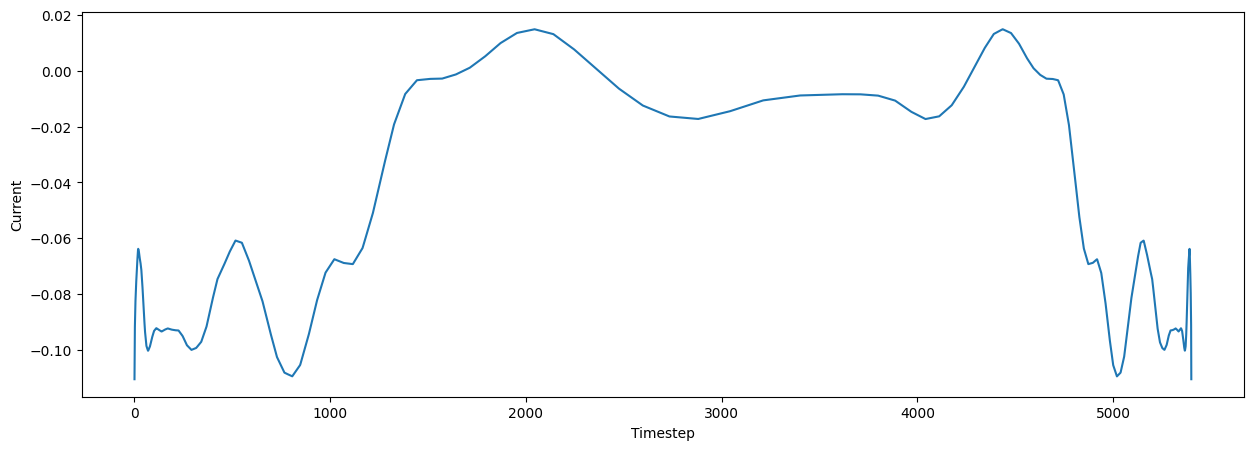

In [6]:
#graph
plt.figure(figsize=(15, 5))
plt.plot(depth_df.index,depth_df.current)
plt.xlabel('Timestep')
plt.ylabel('Current')

In [7]:
depth_df.to_csv("../data/trench_dive_current_U")

In [8]:
#now V
# Use the correct coordinate lengths from subset2
array2 = xr.DataArray(
    subset2.V.data,
    dims=['depth', 'lat', 'lon'],
    coords={
        'depth': subset2.Z.data,
        'lat': subset2.YC.data[:, 0],  # Ensure it uses the correct slice
        'lon': subset2.XC.data[0, :]   # Ensure it uses the correct slice
    }
)

In [10]:
depth = 82

down_data = array2.sel(lat=down_lat,lon=down_lon,method='nearest') #Milwaukee Trench

down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
up_data = array2.sel(lat=up_lat,lon=up_lon,method='nearest')
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32


#here we scale the data to the required number of steps
i1=0; i2=depth;
tem = down_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,3600)
down_data2 = tem.interp(depth=depth_new)
down_lowest = down_data2[-1].data #save lowest value

tem = up_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,1699)
up_data2 = tem.interp(depth=depth_new)
up_lowest = up_data2[-1].data #save lowest value

In [11]:
down_data = pd.DataFrame({'depth': down_data2.depth, 'current': down_data2})
up_data = pd.DataFrame({'depth': up_data2.depth, 'current': up_data2})


down_last = down_data.iloc[-1]
up_last = up_data.iloc[-1]

# Generate linearly interpolated values between the last row of down_data and up_data
depth_interpolated = np.linspace(down_last['depth'], up_last['depth'], 101)
current_interpolated = np.linspace(down_last['current'], up_last['current'], 101)

# Create the middle_data DataFrame
middle_data = pd.DataFrame({
    'depth': depth_interpolated,
    'current': current_interpolated
})

# Display the new DataFrame
print(middle_data)

          depth   current
0   -4019.10498  0.004367
1   -4019.10498  0.004367
2   -4019.10498  0.004367
3   -4019.10498  0.004367
4   -4019.10498  0.004367
..          ...       ...
96  -4019.10498  0.004367
97  -4019.10498  0.004367
98  -4019.10498  0.004367
99  -4019.10498  0.004367
100 -4019.10498  0.004367

[101 rows x 2 columns]


In [12]:
down_data.head()

,depth,current
0,-0.500000,0.077963
1,-1.616589,0.084200
2,-2.733179,0.086587
3,-3.849768,0.087868
4,-4.966357,0.088673


In [13]:
#reverse up data
reversed_up_data = up_data.iloc[::-1].reset_index(drop=True)
depth_df = pd.concat([down_data, middle_data, reversed_up_data], ignore_index=True)

Text(0, 0.5, 'Current')

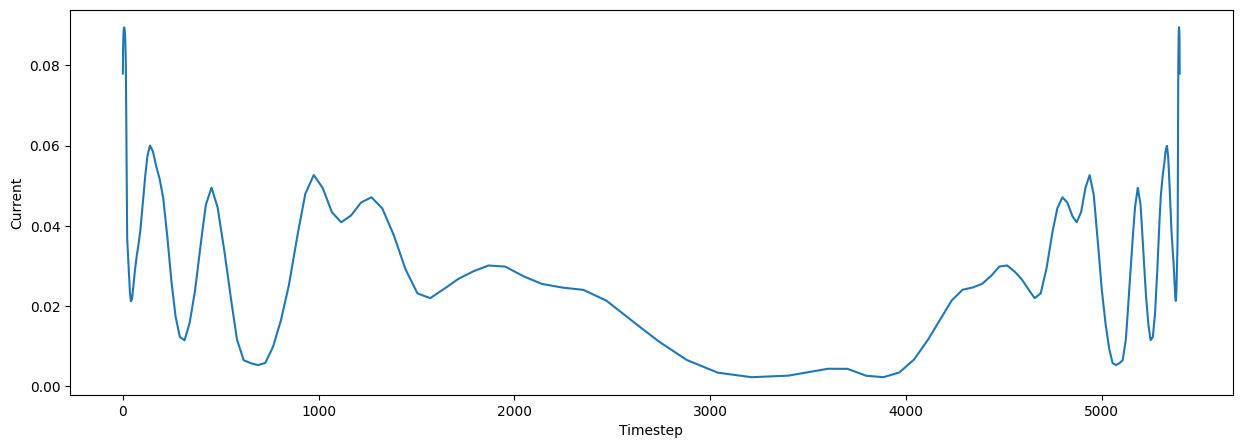

In [14]:
#graph
plt.figure(figsize=(15, 5))
plt.plot(depth_df.index,depth_df.current)
plt.xlabel('Timestep')
plt.ylabel('Current')

In [15]:
depth_df.to_csv("../data/trench_dive_current_V")

# now do W?

In [1]:
import numpy as np
import xarray as xr
import xmitgcm.llcreader as llcreader
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
model = llcreader.ECCOPortalLLC2160Model()
ds = model.get_dataset(varnames=['W'], type='latlon')

# Define down and up coordinates
down_lat = 19.71361
down_lon = -67.00
down_ilat = abs(ds.YC[:, 0] - down_lat).argmin()
down_ilon = abs(ds.XC[0, :] - down_lon).argmin()

up_lat = 19.71361
up_lon = -68.00
up_ilat = abs(ds.YC[:, 0] - up_lat).argmin()
up_ilon = abs(ds.XC[0, :] - up_lon).argmin()

# Load the index values
down_ilat, down_ilon = down_ilat.load(), down_ilon.load()
up_ilat, up_ilon = up_ilat.load(), up_ilon.load()

# Correct the subset to ensure the slices are correctly applied
#ds.isel(time=-1,j=slice(4645,4655),j_g=slice(4645,4655),i=slice(7640,7650),i_g=slice(7640,7650),k=slice(0,50),k_u=slice(0,50),k_l=slice(0,50),k_p1=slice(0,50))
subset2 = ds.isel(
    time=-1,
    j=slice(down_ilat.data - 2, down_ilat.data + 2),
    i=slice(down_ilon.data - 2, down_ilon.data + 2),
    j_g=slice(down_ilat.data - 2, down_ilat.data + 2),
    i_g=slice(down_ilon.data - 2, down_ilon.data + 2),
    k=slice(0, 82),
    k_u=slice(0,82),
    k_l=slice(0,82),
    k_p1=slice(0,82)
)

In [3]:
# Use the correct coordinate lengths from subset2
array2 = xr.DataArray(
    subset2.W.data,
    dims=['depth', 'lat', 'lon'],
    coords={
        'depth': subset2.Z.data,
        'lat': subset2.YC.data[:, 0],  # Ensure it uses the correct slice
        'lon': subset2.XC.data[0, :]   # Ensure it uses the correct slice
    }
)

In [4]:
depth = 82

down_data = array2.sel(lat=down_lat,lon=down_lon,method='nearest') #Milwaukee Trench

down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
up_data = array2.sel(lat=up_lat,lon=up_lon,method='nearest')
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32


#here we scale the data to the required number of steps
i1=0; i2=depth;
tem = down_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,3600)
down_data2 = tem.interp(depth=depth_new)
down_lowest = down_data2[-1].data #save lowest value

tem = up_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,1699)
up_data2 = tem.interp(depth=depth_new)
up_lowest = up_data2[-1].data #save lowest value

In [5]:
down_data = pd.DataFrame({'depth': down_data2.depth, 'current': down_data2})
up_data = pd.DataFrame({'depth': up_data2.depth, 'current': up_data2})


down_last = down_data.iloc[-1]
up_last = up_data.iloc[-1]

# Generate linearly interpolated values between the last row of down_data and up_data
depth_interpolated = np.linspace(down_last['depth'], up_last['depth'], 101)
current_interpolated = np.linspace(down_last['current'], up_last['current'], 101)

# Create the middle_data DataFrame
middle_data = pd.DataFrame({
    'depth': depth_interpolated,
    'current': current_interpolated
})

# Display the new DataFrame
print(middle_data)

          depth  current
0   -4019.10498 -0.00076
1   -4019.10498 -0.00076
2   -4019.10498 -0.00076
3   -4019.10498 -0.00076
4   -4019.10498 -0.00076
..          ...      ...
96  -4019.10498 -0.00076
97  -4019.10498 -0.00076
98  -4019.10498 -0.00076
99  -4019.10498 -0.00076
100 -4019.10498 -0.00076

[101 rows x 2 columns]


In [6]:
#reverse up data
reversed_up_data = up_data.iloc[::-1].reset_index(drop=True)
depth_df = pd.concat([down_data, middle_data, reversed_up_data], ignore_index=True)

Text(0, 0.5, 'Current')

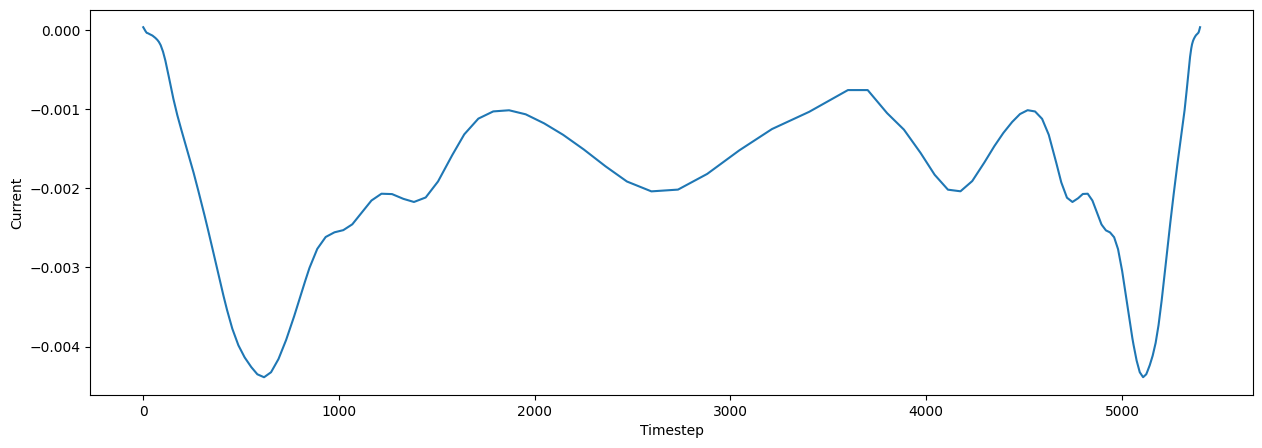

In [7]:
#graph
plt.figure(figsize=(15, 5))
plt.plot(depth_df.index,depth_df.current)
plt.xlabel('Timestep')
plt.ylabel('Current')

In [8]:
depth_df.to_csv("../data/trench_dive_current_W")